In [3]:
from gutenbergpy.gutenbergcache import GutenbergCache, GutenbergCacheTypes
import os
import json
import pandas as pd
import numpy as np
import pickle as pkl


## Exploring the Data Distribution of Project Gutenberg
Our first step in developing a sampling approach is to determine what metadata is available and how best to create a rich, diverse sample for language modeling. We start by initializing the cache and looking at the schema:

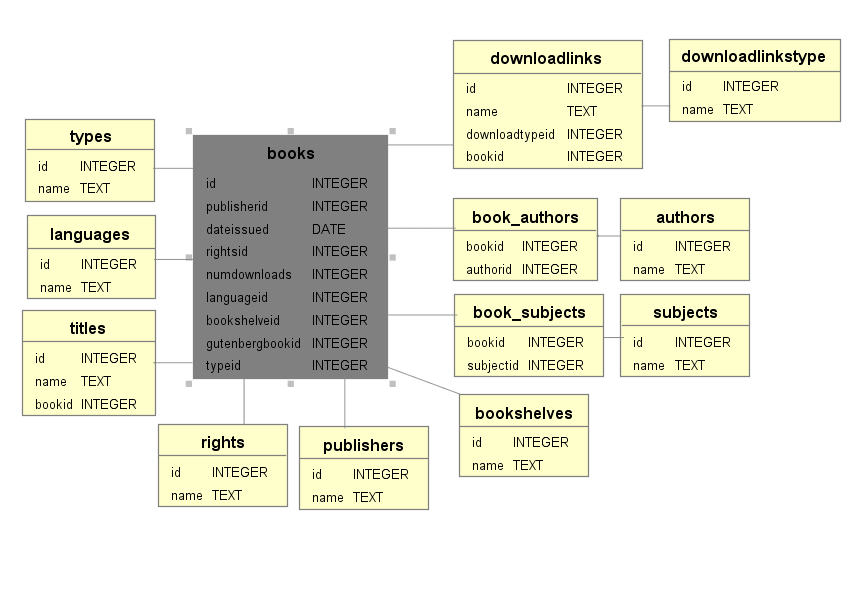

In [5]:
cache  = GutenbergCache.get_cache()
from IPython.display import Image
Image(filename='sqlitescheme.png') 

#### Types of Media

We want our sample to consist solely of text based media; however, the type field is not well maintained for the majority of the works on project gutenberg.

In [7]:
types = [t for t in cache.native_query("SELECT DISTINCT id, name FROM types")]
types

[(1, 'Sound'),
 (2, 'Image'),
 (3, 'Dataset'),
 (4, 'Collection'),
 (5, 'Text'),
 (6, 'MovingImage'),
 (7, 'StillImage')]

#### Gathering Bookshelves

Books on Project Gutenberg are sorted into collections called bookshelves; there are Main Categories each with their own Bookshelf ID; we are interested in English Language (Language.id = 1) text (type.id = 5) texts. However, it also seems that bookshelves themselves are not well populated in the metadata either, meaning a new approach is warranted.

In [12]:
shelves = [sh for sh in cache.native_query("SELECT * FROM (" +
                                           "SELECT bs.id, bs.name, COUNT(b.id) as BOOK_COUNT FROM " +
                                          "(SELECT DISTINCT id, name FROM bookshelves) as bs " +    
                                           "RIGHT JOIN " + 
    "(SELECT id, bookshelveid, languageid, typeid FROM books " + 
    "WHERE languageid=1) as b " +
    "ON bs.id=b.bookshelveid) as bbs " +
    "GROUP BY bbs.id, bbs.name " + 
    "ORDER BY BOOK_COUNT DESC;")]

shelves


[(1, 'The Great Round World And What Is Going On In It', 56673)]

#### Subjects vs. Book Subjects In Project Gutenberg

In [14]:

# Retrieves all subjects

subjects = [s for s in cache.native_query(
    "SELECT bs.subjectid, s.name, count(bs.bookid) AS book_count FROM book_subjects AS bs \
    LEFT JOIN subjects AS s \
    ON s.id = bs.subjectid \
    GROUP BY s.id, s.name \
    ORDER BY book_count DESC \
    LIMIT 25;")]

# See the script "subjectid.sql" for a full listing of the actual subject names
subjects

[(44, 'PS', 11113),
 (10, 'PR', 10009),
 (13, 'PZ', 7282),
 (16, 'PQ', 4843),
 (28, 'PT', 2956),
 (80, 'Science fiction', 2938),
 (14, 'Short stories', 2748),
 (2, 'AP', 2583),
 (71, 'Fiction', 1979),
 (46, 'DA', 1663),
 (105, 'Adventure stories', 1475),
 (146, 'PH', 1379),
 (18, 'PN', 992),
 (79, 'DC', 961),
 (308, 'Historical fiction', 947),
 (91, 'DS', 943),
 (30, 'Conduct of life -- Juvenile fiction', 876),
 (158, 'Love stories', 858),
 (291, 'D501', 827),
 (192, 'Detective and mystery stories', 818),
 (51, 'Man-woman relationships -- Fiction', 809),
 (197, 'BX', 745),
 (29, 'Poetry', 681),
 (68, 'QH', 670),
 (242, 'QL', 670)]

#### Querying a Subject

Some of the subject titles aren't particularly informative; in order to get a better picture of what each subject is, we can query them individually to retrieve top downloads for each subject:  

In [17]:
# Top N Downloads for subject ID:

top25 = [s for s in cache.native_query(
    "SELECT bs.subjectid, b.name, b.numdownloads FROM \
    (SELECT * FROM books \
     LEFT JOIN titles AS T \
     ON T.bookid = books.id) AS b \
    LEFT JOIN book_subjects AS bs \
    ON b.id = bs.bookid and bs.subjectid=44 \
    ORDER BY b.numdownloads DESC \
    LIMIT 25;")]

# See the script "subjectid.sql" for a full listing of the actual subject names

top25

[(None, 'Romeo and Juliet', 197127),
 (None, 'A Room with a View', 167726),
 (None, 'Middlemarch', 165079),
 (44, 'Little Women; Or, Meg, Jo, Beth, and Amy', 152480),
 (44, 'Moby Dick; Or, The Whale', 148386),
 (None, 'The Enchanted April', 147692),
 (44, 'The Blue Castle: a novel', 147236),
 (None, 'The Complete Works of William Shakespeare', 147074),
 (None, 'Cranford', 143503),
 (None, 'The Adventures of Ferdinand Count Fathom — Complete', 141299),
 (None, 'The Expedition of Humphry Clinker', 139335),
 (None, 'The Adventures of Roderick Random', 137522),
 (None, 'History of Tom Jones, a Foundling', 131062),
 (None, 'Twenty Years After', 128560),
 (None, 'Vingt ans après. English', 128560),
 (None, 'My Life — Volume 1', 128316),
 (None, 'Frankenstein; Or, The Modern Prometheus', 75145),
 (None, 'Pride and Prejudice', 68103),
 (None, 'Alice in Wonderland', 31948),
 (None, "Alice's Adventures in Wonderland", 31948),
 (44, 'The Great Gatsby', 25354),
 (44, 'The Yellow Wallpaper', 24783)

#### Querying an Author

In our analysis, we intend to have the model attempt to learn to detect different writers for based on their style of writing; in order to do this, we need a good sample of writers for each subject.

In [18]:
topAuthors = [s for s in cache.native_query(
    "SELECT a.authorid, a.name, count(a.bookid) as book_count from \
    (SELECT * from authors \
    LEFT JOIN book_authors \
    ON id = authorid) as a \
    LEFT JOIN books as b \
    ON b.id = a.bookid \
    GROUP BY a.id, a.name \
    ORDER BY book_count DESC \
    LIMIT 100;")]

# Note this is the authors with the most books, not the authors with most downloads
# Furthermore, there are many repeats in the list of authors; Shakespeare appears 3 times, Jules Verne 4
topAuthors

[(1, 'Verschillende', 3818),
 (3, 'Various', 3818),
 (2, 'Various, Various', 3813),
 (125, 'Anonyme', 892),
 (127, 'Anonymous', 892),
 (126, 'Anonymous, Anonymous', 887),
 (1076, 'Shakspeare, William', 332),
 (1077, 'Shakspere, William', 332),
 (1078, 'Shakespeare, William', 332),
 (85, 'Clemens, Samuel Langhorne', 245),
 (86, 'Twain, Mark (Samuel Clemens)', 245),
 (87, 'Twain, Mark', 245),
 (1042, 'Bulwer-Lytton, Edward George Earle Lytton, 1st Baron', 226),
 (1043, 'Bulwer, Edward Lytton', 226),
 (1045, 'Lytton, Edward Bulwer Lytton, Baron', 226),
 (1044, 'Lytton, Edward Bulwer', 225),
 (400, 'Dickens, Charles John Huffam', 189),
 (401, 'Boz', 189),
 (402, 'Dickens, Charles', 189),
 (2199, 'Verne, Júlio', 175),
 (2200, 'Verne, Jules Gabriël', 175),
 (2201, 'Verne, Jules Gabriel', 175),
 (2203, 'Verne, Jules', 175),
 (3895, 'Ebers, Georg Moritz', 175),
 (3896, 'Ebers, George Moritz', 175),
 (3897, 'Ebers, Georg', 175),
 (2202, 'Verne, Gyula', 157),
 (583, 'Balzac, Honore de', 153),
 (